In [ ]:
 get_ipython().system('pip install tensorflow')

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
# Definning some useful variables

IMAGE_SIZE = 256
batch_size = 32
channels = 3
epochs = 50

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= batch_size
)

Found 416 files belonging to 2 classes.


In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= batch_size
)

Found 134 files belonging to 2 classes.


###### Getting the name of each class 

In [4]:
class_names = dataset.class_names
class_names

['Parasite', 'Uninfected']

###### The structure of the data

In [5]:
print('there are', len(dataset), 'batches in the data set. Each batch has at least', [len(i[0]) for i in dataset.take(1)], 'images')

there are 13 batches in the data set. Each batch has at least [32] images


In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[31].shape)
    print(label_batch.numpy())

(256, 256, 3)
[1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0]


###### Visualize image

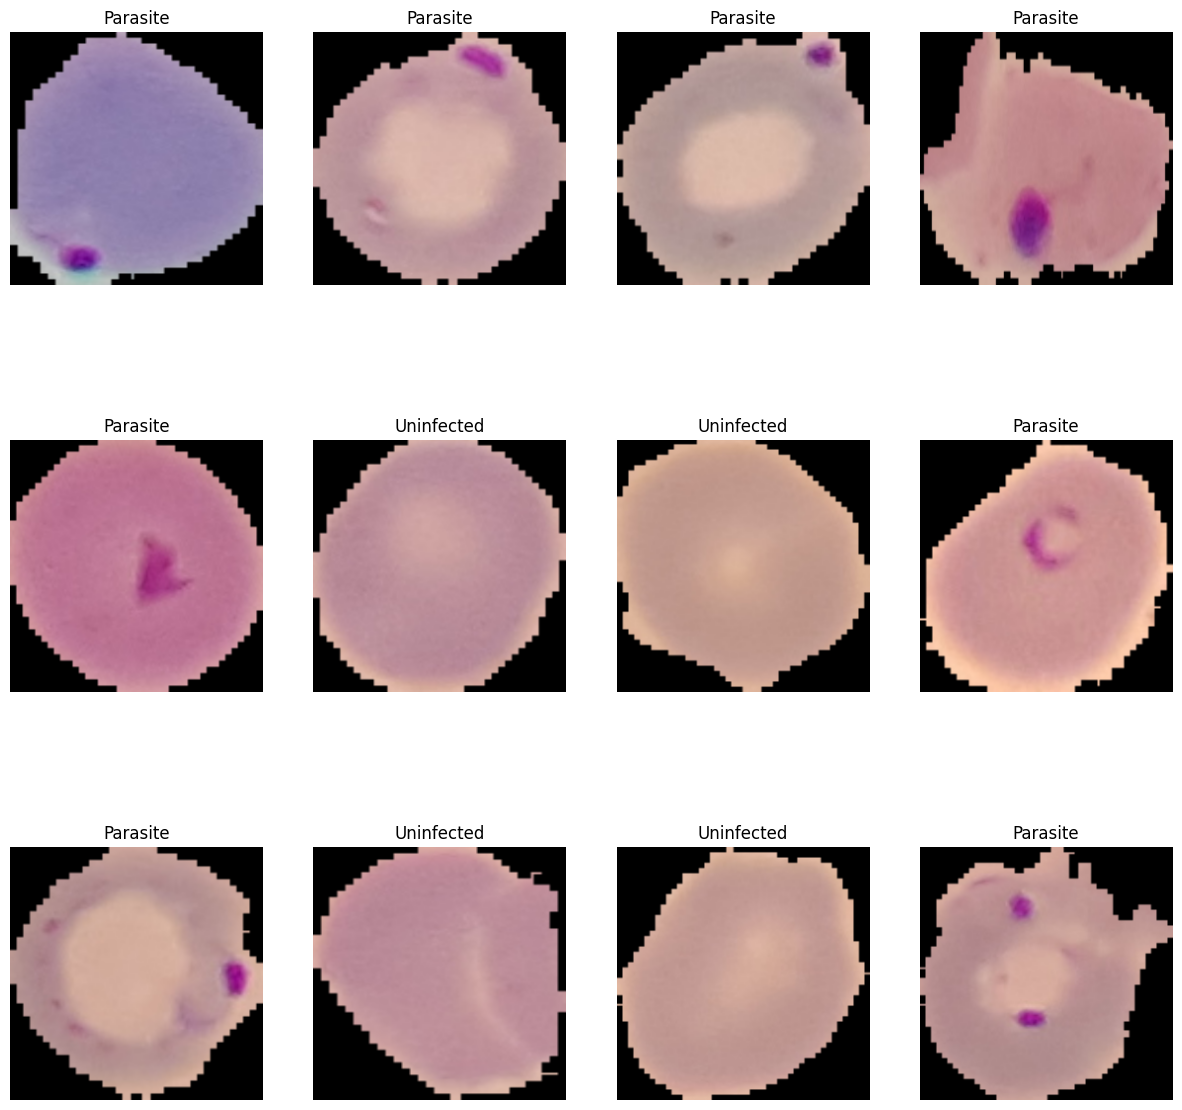

In [7]:
plt.figure(figsize=(15, 15))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')


#### Splitting the data into training and testing

In [8]:
print('Dataset\'s size: ', len(dataset))

# ------------ Splitting methodology ------------
# So,
# 80% ==> training
# 20% ==> 10% for testing, 10% for validation

Dataset's size:  13


In [103]:
# Split the data this way

# the training dataset
train_perc = 0.8
train_size = len(dataset) * train_perc
train_ds = dataset.take(int(train_size))

# to get the temporal test dataset, skip the first 54 sets
test_ds = dataset.skip(54)

# So, to get the validataion dataset, get the 10% of the test_ds
val_perc = 0.5
val_size = len(test_ds)*val_perc
val_ds = test_ds.take(int(val_size))

#  the final test dataset
test_ds = test_ds.skip(7)

###### Put the above code in a function 

In [104]:
# this is a function for data splitting

def split_data(ds, train_split=0.8, test_split=.1, val_split=.1, shuffle=True, shuffle_size =1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    train_ds = ds.take(train_size) # training dataset
    
    val_size = int(val_split * ds_size)
    
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, test_ds, val_ds

###### Split the data here to
- train
- test
- validation

In [105]:
train_ds, test_ds, val_ds = split_data(dataset)

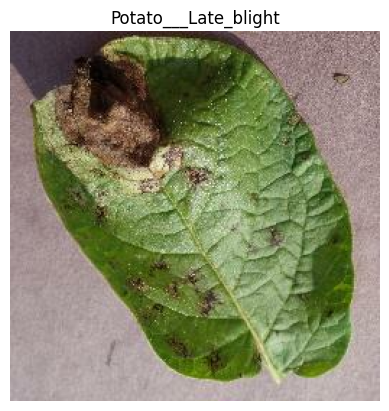

In [110]:
for batch, name in train_ds.take(1):
    image = batch[0].numpy().astype('uint8')
    label_of_image = class_names[name[0]]
    plt.imshow(image)
    plt.title(label_of_image)
    plt.axis('off')

###### Doing data cacheing and prefetching

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)



#### Doing some preprocessing on the data
- Scaling : dividing the data by 255
- Resizing : 256 by 256

In [16]:
# Using the keras API

# Rescaling and resizing
rescale_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) 
])

# Data Augmentation
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Model Building

In [17]:
input_shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, channels)
input_shape

(32, 256, 256, 3)

In [18]:
input_shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, channels)
n_classes = 3

model = models.Sequential([
    rescale_resize,
    augment,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3),  activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# Build model here
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

###### Compile model

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

###### Fit model

In [22]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=test_ds
)

Epoch 1/50
13/13 [==============================] - 54s 4s/step - loss: 0.8223 - accuracy: 0.4567 - val_loss: 0.6894 - val_accuracy: 0.6269
Epoch 2/50
13/13 [==============================] - 45s 3s/step - loss: 0.6995 - accuracy: 0.5024 - val_loss: 0.7100 - val_accuracy: 0.3358
Epoch 3/50
13/13 [==============================] - 49s 4s/step - loss: 0.7017 - accuracy: 0.5024 - val_loss: 0.6456 - val_accuracy: 0.6791
Epoch 4/50
13/13 [==============================] - 47s 4s/step - loss: 0.6890 - accuracy: 0.5529 - val_loss: 0.7358 - val_accuracy: 0.3284
Epoch 5/50
13/13 [==============================] - 45s 4s/step - loss: 0.6969 - accuracy: 0.5240 - val_loss: 0.7346 - val_accuracy: 0.3209
Epoch 6/50
13/13 [==============================] - 46s 4s/step - loss: 0.6837 - accuracy: 0.5649 - val_loss: 0.6779 - val_accuracy: 0.6791
Epoch 7/50
13/13 [==============================] - 47s 4s/step - loss: 0.6260 - accuracy: 0.6418 - val_loss: 1.2000 - val_accuracy: 0.3358
Epoch 8/50
13/13 [==

###### Testing the model

In [23]:
score = model.evaluate(test_ds)
print('score: ', score)

5/5 [==============================] - 4s 694ms/step - loss: 0.3014 - accuracy: 0.8955
score:  [0.301443487405777, 0.89552241563797]


###### We have saved all the elements that was used in the training process in a variable called history. We can access as many things as possible from the history of the variable

In [24]:
# Accessing the paramenters
print('the parameters used in the model: ', history.params)

# Accessing the keys
print('the keys: ', history.history.keys())

the parameters used in the model:  {'verbose': 1, 'epochs': 50, 'steps': 13}
the keys:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Traning and Validation Loss')

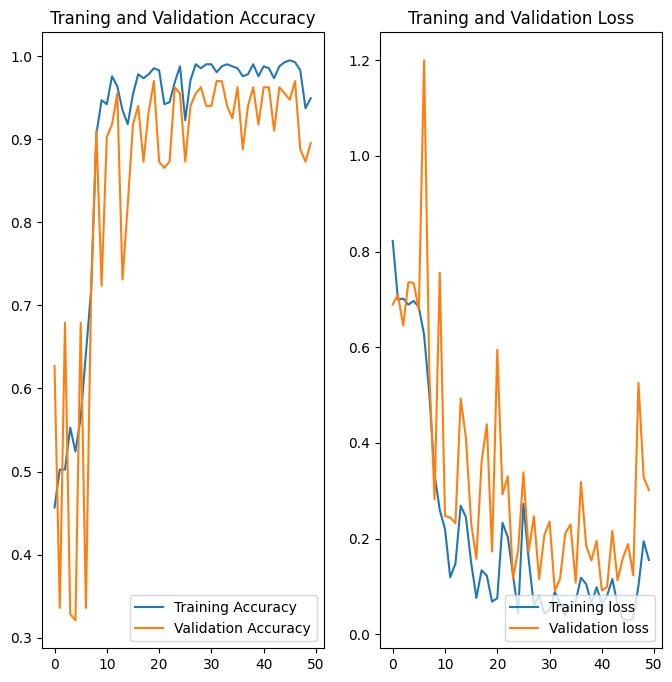

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traning and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training loss')
plt.plot(range(epochs), val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Traning and Validation Loss')

##### Let's make a prediction with this

First image to predict
Actual name of the first image:  Parasite
1/1 [==============================] - 1s 1s/step
Predicted label Parasite


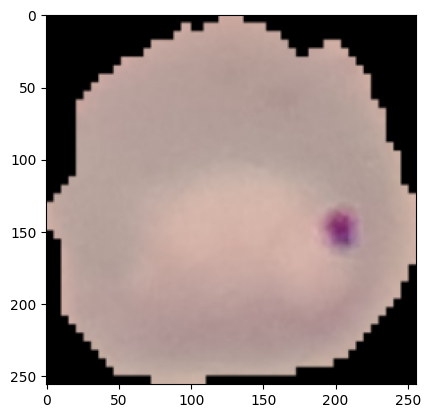

In [34]:
import numpy as np
for image_batch, label_batch in dataset.take(1):
    
    first_image = image_batch[0].numpy().astype('uint32')
    first_label = class_names[label_batch[0].numpy()]
    
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual name of the first image: ', first_label)
    
    # Let's do the prediction
    batch_prediction = model.predict(image_batch)
    print('Predicted label', class_names[np.argmax(batch_prediction[0])])

#### Save the model 

In [45]:
import os

# this sutomatically generate a new model version greater than the previous version by one
model_version = max([int(i) for i in os.listdir('models') + [0]]) + 1
model.save(f'models/{model_version}')
# model_version

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [127]:
version = 1
model.save(f'../models/1')

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


## Testing the model

In [46]:
from PIL import Image
import numpy as np
from io import BytesIO
from tensorflow.keras.applications.imagenet_utils import preprocess_input


In [1]:
model = tf.keras.models.load_model('models/1')
# pic = Image.open('PlantVillage/Potato___healthy/07dfb451-4378-49d1-b699-33a5fc49ff07___RS_HL 5399.JPG')

pic = Image.open('Dataset/Test/Parasite/C39P4thinF_original_IMG_20150622_105554_cell_15.png')
pic = pic.resize((256, 256))
pic_array = np.array(pic)
pic_arrays = np.expand_dims(pic_array, 0)
pic_array = pic_array.reshape((1, 256, 256, 3))


class_names[np.argmax(model.predict(pic_arrays))]

NameError: name 'tf' is not defined

In [52]:
class_names

['Parasite', 'Uninfected']

In [53]:
for batch, name in train_ds.take(1):
    print(batch[0].numpy().astype('uint8').shape)

(256, 256, 3)
